In [1]:
import sys
sys.path.insert(1, '/home/afkirby/PEnGUIn/read/Analysis')

In [2]:
from read_penguin import load_3D_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import geometry as geo
from Interpolate import triInterpolate
from Search import binSearch

In [3]:
#Function to interpolate the densities to a given cartesian coordinate (x, y, z) from a polar data source

def density(x, y, z, data):
    xVals = data[1]
    yVals = data[2]
    zVals = data[3]
    dens = data[4]
    
    #Finding indices in the data between which the target points lie
    xPoints = binSearch(xVals, 0, len(xVals), x)
    yPoints = binSearch(yVals, 0, len(yVals), y)
    zPoints = binSearch(zVals, 0, len(zVals), z) 
    
    #Applying Boundary Conditions (y and z in this case is angle, so it should be periodic but x is radius so anything outside of data set is made to be 0)
    if(xPoints[0] == -np.infty):
        return 0
    elif(xPoints[1] == np.infty):
        return 0
    if(yPoints[0] == -np.infty):
        yPoints = (0, len(yVals)-2)
    elif(yPoints[1] == np.infty):
        yPoints = (len(yVals)-2, 0)
    if(zPoints[0] == -np.infty):
        return 0
    elif(zPoints[1] == np.infty):
        return 0
        
    #Setting up grid points for interpolation 
    lowx = xPoints[0]
    highx = xPoints[1]
    lowy = yPoints[0]
    highy = yPoints[1]
    lowz = zPoints[0]
    highz = zPoints[1]
    
    #Creating values at each cube lattice point and interpolating
    
    targetCoords = (x,y,z)
    minCoords = (xVals[lowx], yVals[lowy], zVals[lowz])
    maxCoords = (xVals[highx], yVals[highy], zVals[highz])
    
    cubeVals = [dens[lowz,lowy,lowx], dens[lowz,highy,lowx], dens[lowz,lowy,highx], dens[highz,lowy,lowx], dens[lowz,highy,highx], dens[highz,lowy,highx], dens[highz,highy,lowx], dens[highz,highy,highx]]
    
    den = triInterpolate(targetCoords, cubeVals, minCoords, maxCoords)
    geo.sphericalToCartesian(targetCoords, den, dim = 3)
    return den
    

In [4]:
#Function to interpolate from the 2D cartesian grid to another 2D polar grid
#Assumes cartesiaan boundary conditions instead of polar (i.e. everything outside of data range is 0)
#The different inputs are due to not assuming that the data coming is from read_penguin

def cartDensity(x, y, z, xVals, yVals, zVals, dens):
    xPoints = binSearch(xVals, 0, len(xVals), x)
    yPoints = binSearch(yVals, 0, len(yVals), y)
    zPoints = binSearch(zVals, 0, len(zVals), z)
    
    if(xPoints[0] == -np.infty or yPoints[0] == -np.infty):
        return 0
    if(xPoints[1] == np.infty or yPoints[1] == np.infty):
        return 0
    
    lowx = xPoints[0]
    highx = xPoints[1]
    lowy = yPoints[0]
    highy = yPoints[1]
    lowz = zPoints[0]
    highz = zPoints[0]
    
    cubeVals = [dens[lowz,lowy,lowx], dens[lowz,highy,lowx], dens[lowz,lowy,highx], dens[highz,lowy,lowx], dens[lowz,highy,highx], dens[highz,lowy,highx], dens[highz,highy,lowx], dens[highz,highy,highx]]
    targetCoords = (x,y,z)
    minCoords = (xVals[lowx], yVals[lowy], zVals[lowz])
    maxCoords = (xVals[highx], yVals[highy], zVals[highz])
    den = triInterpolate(targetCoords, cubeVals, minCoords, maxCoords)
    polar = geo.cartesianToSpherical(cartesian, 3)
    return polar

In [10]:
#Loading density data

xres = 384
yres = 768
zres = 216
data = load_3D_data("/scratch/afkirby/3DAdiabaticParameterChange/Gamma1.4/", xres, yres, zres, "h50_1p1J_e0_PPM4", 28)


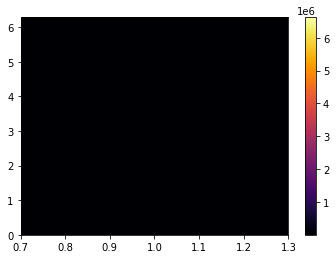

In [11]:
plt.pcolor(data[1],data[2],data[4][-1], cmap="inferno")
plt.colorbar()
plt.show()

In [12]:
#Creating cartesian grid/defining planet position in both coordinate systems

coordX = np.ndarray(251)
coordY = np.ndarray(251)
coordZ = np.ndarray(101)
planetCoords = (1, np.pi, np.pi/2)
planetCoordsCart = geo.sphericalToCartesian(planetCoords, dim = 3)

In [13]:
#Populating Cartesian Grid

for i in range(251):
    coordX[i] = -data[1][-1] + 2*data[1][-1]*(i)/250
    
for j in range(251):
    coordY[j] = -data[1][-1] + 2*data[1][-1]*(j)/250

for k in range(101):
    coordZ[k] = -data[1][-1] + 2*data[1][-1]*(k)/100


In [14]:
#Interpolating over polar array to find data for cartesian coordinates

gam10denCart = np.ndarray((101,251,251))
for k in range(101):
    for j in range(251):
        for i in range(251):
            cartesian = (coordZ[k], coordY[j], coordX[i])
            polar = geo.cartesianToSpherical(cartesian, 3)
            gam10denCart[k,j,i] = density(polar[0], polar[1], polar[2], data)

TypeError: sphericalToCartesian() got multiple values for argument 'dim'

In [ ]:
#Shifting Cartesian Grid to be planet-centric

for i in range(251):
    coordX[i] = coordX[i] - planetCoordsCart[0]
    coordY[i] = coordY[i] - planetCoordsCart[1]
for i in range(101):
    coordZ[i] = coordZ[i] - planetCoordsCart[2]

#Creating planet-centric polar grid

gam10denplanet = np.ndarray((xres, yres, zres))
planetR = np.ndarray(xres+1)
planetTheta = np.ndarray(yres+1)
planetPhi = np.ndarray(zres+1)

for i in range(xres+1):
    planetR[i] = 0.9*i/(xres)
for j in range(yres+1):
    planetTheta[j] = 2*np.pi*j/(yres)
for k in range(zres+1):
    planetPhi[k] = np.pi*k/(zres)

#Interpolating over cartesian grid to find data for the new, planet-centric, polar grid
for i in range(xres):
    for j in range(yres):
        for k in range(zres):
            polar = (planetR[i], planetTheta[j], planetPhi[k])
            cartesian = geo.sphericalToCartesian(polar, 3)
            gam10denplanet[i,j,k] = cartDensity(cartesian[0], cartesian[1], cartesian[2], coordX, coordY, coordZ, gam10denCart)
            

In [ ]:
#Plotting
if __name__ == "__main__":
    plt.figure()
    plt.pcolor(planetTheta, planetR, gam10denplanet)
    plt.title("Final Planet-Centric Isothermal Density")
    plt.xlabel("Theta (Rad)")
    plt.ylabel("R (Planet a)")
    plt.colorbar()
    plt.savefig(filepath + "Gamma1.0FinalDensityPolarPlanet.png")
    plt.show()